# Adding a cut in front of an NN

We've shown we can train a cut (`sigmoid` or `erf`) and also train seperately a NN to separate signal from background. Can we do both? Here we will add two cuts in front of the same NN we used last time.

In [2]:
import jax
import jax.numpy as jnp
import numpy
import matplotlib.pyplot as plt
from samples import data_back, sig_avg, sig_width
from jax_helpers import erf, train
import haiku as hk
from typing import List, Optional
from jax_training import Selection, train
from jax_cuts import cut_erf, cut_sigmoid
from copy import deepcopy

_ = plt.ion()

Load up the 2D data. This is identical to what we've done before.

In [3]:
key = jax.random.PRNGKey(1234)
signal_data = jax.random.multivariate_normal(key, jnp.asarray([1.5, 2.0]), jnp.asarray([[0.5, 0.2], [0.2, 0.5]]), [40000])
key, _ = jax.random.split(key)
background_data = jax.random.multivariate_normal(key, jnp.asarray([0.0, 0.0]), jnp.asarray([[9.0, 0.0], [0.0, 9.0]]), [40000])

Build the training and truth data. Keep the testing and training data the same, and the full data sample for now because we are lazy.

In [4]:
all_data = jnp.concatenate((signal_data, background_data))
all_truth = jnp.concatenate((jnp.ones(len(signal_data)), jnp.zeros(len(background_data))))

training_data = all_data
training_truth = all_truth

testing_signal = signal_data
testing_background = background_data

## Building blocks for the network

We will use the same network MLP as in the previous chapter, but will add a parallel network that implements the cut. We'll multiply the result of this network by the MLP result, so the cut can _turn on-turn off_ the MLP output:

$$
P = \textrm{cut}(x_1)*\textrm{cut}(x_2)*\textrm{MLP}({x_i})
$$

In order to do this, however, we have to build some new modules that are useful with `haiku`. We'll need:

* Concatenate - takes two other modules and just concatenates the outputs of each together. This is an infrastructure module and it is because we need the two selection cuts and the MLP to appear as a single row as input to the multiplication module.
* Multiplication - `n -> 1` multiplies each row of the input vector together (implementes the $*$ operators above).

We use the `Selection` module from the previous chapter to power the cut itself.

### Multiplication Module

Implement a simple module that multiplies everything in a row together. This will take the weight from the cuts and mulitply it by the output of the NN.

In [5]:
class MultiplyRow(hk.Module):
    'Multiply all elements of input together'

    def __init__(self, name='Multiply'):
        super().__init__(name=name)
    
    def __call__(self, x):
        'Multiply all elements of x'
        r = jnp.prod(x, axis=1)
        return r

### Concatenate

This layer is odd because it takes as input two other layers, pushes the same inputs to each layer, and then returns the outputs concatinated together. So it doesn't exactly follow the previous patterns (or standard `haiku` patterns for that matter). We will only implement this for starting from the same data - because I do not know how to do this otherwise.

* If this had to be generalized, one could change the `__call__` method to have two inputs, rather than listing them in the `ctor` - but that depends on weather the `__call__` is called under any other circumstances than network initalization.

In [6]:
class ModuleConcat(hk.Module):
    """Concatenate the outputs of two different networks that
    use the same data"""

    def __init__(self, name="ModuleConcat"):
        super().__init__(name=name)

    def __call__(self, x):
        c = jnp.concatenate(x, axis=1)
        return c

## MLP + Selection Cut Network

Build a function that will build the forward network that combines all of this now and implements the above network (the normal way that `haiku` works).

In [7]:
def CutsAndMLP(f_cut, initial_cuts=(1.0, 1.0)):
    '''Build the network that combines a cut with the MLP afterburner - the idea
    is everything is trained at the same time.

    Args:
        f_cut (Callable): The `cut_xxx` function that implements a differentiable cut
    '''
    def func_network(x):
        '''Build the NN with the `f_cut`

        Args:
            x (JAXArray): The array we will operate on

        Returns:
            Haiku: Built network
        '''
        # The NN MLP training
        mlp = hk.nets.MLP(output_sizes=[2,15,30,15,1])

        # The selection
        selection = Selection(f_cut, initial_cuts=initial_cuts)

        # Now the concat. Both these operate on the same input data (the tuple of
        # values) - which is required for this concat to work.
        combiner = ModuleConcat()

        # And run the stuff through it
        cut_result = jnp.reshape(selection(x), (x.shape[0], 1))
        mlp_result = mlp(x)
        combine_result = combiner((cut_result, mlp_result))

        # And then the multiply
        final = MultiplyRow()

        # And put them together in the proper way
        return final(combine_result)

    return func_network

model_sigmoid = hk.transform(CutsAndMLP(cut_sigmoid))
model_erf = hk.transform(CutsAndMLP(cut_erf))

## Train

The training loop is the same as others we've used:

In [8]:
params_sigmoid = train(model=model_sigmoid,
    key = key, 
    epochs = 2000,
    training_data=training_data,
    training_truth=training_truth)

params_erf = train(model=model_erf,
    key = key, 
    epochs = 2000,
    training_data=training_data,
    training_truth=training_truth)

NegLogLoss : 450451.09, epoch: 1
NegLogLoss : 444133.81, epoch: 200
NegLogLoss : 441486.66, epoch: 400
NegLogLoss : 440835.19, epoch: 600
NegLogLoss : 440551.66, epoch: 800
NegLogLoss : 440413.44, epoch: 1000
NegLogLoss : 440329.28, epoch: 1200
NegLogLoss : 440151.44, epoch: 1400
NegLogLoss : 440288.81, epoch: 1600
NegLogLoss : 440262.75, epoch: 1800
NegLogLoss : 440216.94, epoch: 2000
NegLogLoss : 449874.34, epoch: 1
NegLogLoss : 444821.31, epoch: 200
NegLogLoss : 443853.69, epoch: 400
NegLogLoss : 443420.56, epoch: 600
NegLogLoss : 443086.84, epoch: 800
NegLogLoss : 442850.81, epoch: 1000
NegLogLoss : 442651.38, epoch: 1200
NegLogLoss : 442471.41, epoch: 1400
NegLogLoss : 441939.25, epoch: 1600
NegLogLoss : 440897.88, epoch: 1800
NegLogLoss : 440319.12, epoch: 2000


When compared to the straight-up training of the MLP found in the [previous chapter](training-mlp-only), this feels a lot slower:

* Slower to get the loss down. The comparison can be made directly here - because the loss calculation is identical in the two cases.
* The loss started about the same, but by the end of 2000 epochs of training the MLP-only training was down to `439072.69`, which is significantly lower.

Over all on a comparison laptop, it was 9.5 minutes to do 10K epochs here, and 2 minutes to do 2000 there - so about the same. At the end of 10K trainings however, the loss for this combined cut and MLP network is about at where the MLP only training was at 400 epochs. Even at the end of 40K iterations and 40 minutes, it doesn't get as low a loss as the simple MLP training.

In short, the multiplyer method to weight the values doesn't seem to work very well when it comes to training. The question is - what (if anything) is going on and how to fix it (if possible).

## Examining the Training

Lets see if we can see some of the differences going on.

First, look at the weights assigned the signal and data events.

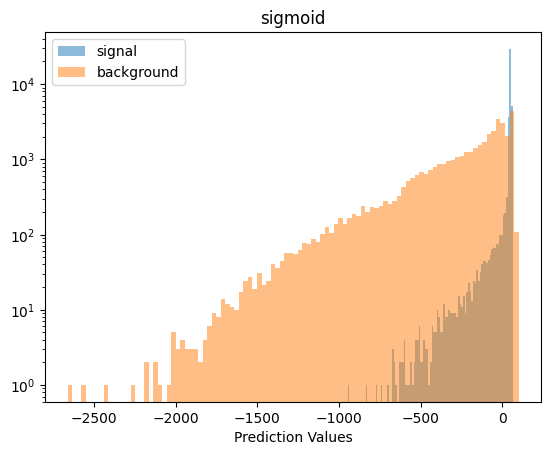

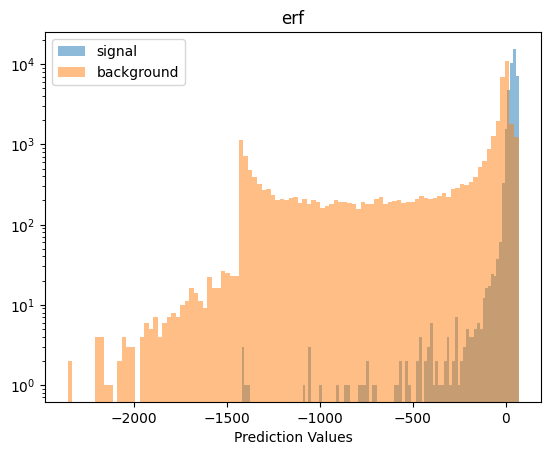

In [9]:
def plot_model_weights(model, params, model_name):

    def plot_it(data, lbl):
        preds = model.apply(params, key, data)
        preds = preds.squeeze()
        # preds = jax.nn.sigmoid(preds)
        # preds = jnp.log(preds)
        plt.hist(preds, bins=100, label=lbl, alpha=0.5)

    plot_it(signal_data, "signal")
    plot_it(background_data, "background")
    plt.yscale("log")
    plt.xlabel("Prediction Values")
    plt.title(model_name)
    plt.legend()
    plt.show()

plot_model_weights(model_sigmoid, params_sigmoid, 'sigmoid')
plot_model_weights(model_erf, params_erf, 'erf')

Note how negative these prediction values get (which amazes me) - down to -2000 after 2000 epochs of training. The plain MLP was down at -60 at worst. If we train even longer, we head even further negative.

I had to shift from negative log loss function to `optax`'s `softmax_cross_entropy` in order to make this work. The reason is that when you hit values of about -45 or so for predicted values, your negative log heads off towards negative infinity.

I do not totally understand why the values get so negative here - then again there is no restriction due to the `softmax` function.

Lets take a look at the cut parameters to see where they ended up (remember, they were initialized to `1`).

In [10]:
trained_cut_values_erf = params_erf['SelectionCut']['cuts']
trained_cut_values_sigmoid = params_sigmoid['SelectionCut']['cuts']
print(f'erf cuts = {trained_cut_values_erf}')
print(f'sigmoid cuts = {trained_cut_values_sigmoid}')

erf cuts = [-1.5120678 -2.7497628]
sigmoid cuts = [-0.9598404 -1.4035522]


So - those don't make much sense - but they have both moved from the `(1.0, 1.0)` start. The interesting thing to watch is what happens when you let the training run for a long time. Then the cuts just continue to go negative forwever. We can see this by starting a training with the cuts already at (-3, -3).

In [11]:
model_sigmoid_negative = hk.transform(CutsAndMLP(cut_sigmoid, initial_cuts=(-4.0, -4.0)))
p_log = []
def add_param(epoch, params):
    p_log.append(params["SelectionCut"]["cuts"])
params_sigmoid_negative = train(model=model_sigmoid_negative,
    key = key, 
    epochs = 8000,
    training_data=training_data,
    training_truth=training_truth,
    epoch_callback=add_param)

NegLogLoss : 449730.12, epoch: 1
NegLogLoss : 439583.81, epoch: 800
NegLogLoss : 439091.16, epoch: 1600
NegLogLoss : 439080.12, epoch: 2400
NegLogLoss : 439076.75, epoch: 3200
NegLogLoss : 439074.69, epoch: 4000
NegLogLoss : 439074.44, epoch: 4800
NegLogLoss : 439073.62, epoch: 5600
NegLogLoss : 439072.16, epoch: 6400
NegLogLoss : 439071.69, epoch: 7200
NegLogLoss : 439071.38, epoch: 8000


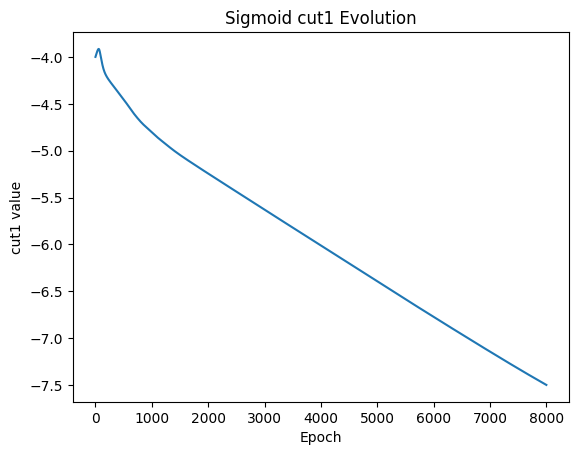

In [12]:
cut1_evolution = [float(i[0]) for i in p_log]
plt.plot(range(0, len(cut1_evolution)), cut1_evolution)
plt.xlabel('Epoch')
plt.ylabel('cut1 value')
plt.title('Sigmoid cut1 Evolution')
plt.show()

In [13]:
print(f'sigmoid cuts, after starting at a negative number = {params_sigmoid_negative["SelectionCut"]["cuts"]}')

sigmoid cuts, after starting at a negative number = [-7.499011 -7.866767]


This also happens with the error function. Not let it run long enough to see where (if) it ends. But we know from the 2D training that when we get far enough away the cut stops. So I assume when it gets negative enough things no longer change:

In [14]:
model_sigmoid_negative = hk.transform(CutsAndMLP(cut_sigmoid, initial_cuts=(-60.0, -60.0)))
p_log = []
def add_param(epoch, params):
    p_log.append(params["SelectionCut"]["cuts"])

params_sigmoid_negative = train(model=model_sigmoid_negative,
    key = key, 
    epochs = 2000,
    training_data=training_data,
    training_truth=training_truth,
    epoch_callback=add_param)

NegLogLoss : 450086.47, epoch: 1
NegLogLoss : 440696.25, epoch: 200
NegLogLoss : 440081.81, epoch: 400
NegLogLoss : 439909.94, epoch: 600
NegLogLoss : 439677.00, epoch: 800
NegLogLoss : 439542.94, epoch: 1000
NegLogLoss : 439482.44, epoch: 1200
NegLogLoss : 439343.94, epoch: 1400
NegLogLoss : 439243.12, epoch: 1600
NegLogLoss : 439136.59, epoch: 1800
NegLogLoss : 439075.34, epoch: 2000


In [15]:
print(f'sigmoid cuts, after starting at a very negative number = {params_sigmoid_negative["SelectionCut"]["cuts"]}')

sigmoid cuts, after starting at a very negative number = [-60. -60.]


Further, note at this point that the training has gotten to the point that it is pretty good, if we look at the loss function values.

Lets look at this graphically, showing a scatter plot of good and bad. We need to build some tools for this.

In [16]:
def plot_in_and_out(model, params):
    def infer(data, p, m = model):
        test_preds = m.apply(p, key, data)
        test_preds = jax.nn.sigmoid(test_preds.squeeze())
        test_preds = (test_preds > 0.5).astype(jnp.float32)
        return test_preds

    infer_signal = infer(testing_signal, params)
    infer_background = infer(testing_background, params)

    def plot_inference(ax, data, results, value, title):
        good_data = data[results == value]
        ax.scatter(good_data[:, 0], good_data[:, 1], color='green', label='correct')
        bad_data = data[results != value]
        ax.scatter(bad_data[:, 0], bad_data[:, 1], color='red', label='misclassified')
        ax.set_title(title)
        ax.legend()

    fig, (ax1,ax2) = plt.subplots(1,2)

    plot_inference(ax1, testing_signal, infer_signal, 1.0, 'Signal')
    plot_inference(ax2, testing_background, infer_background, 0.0, 'Background')
    plt.show()

First for the `simoid` training

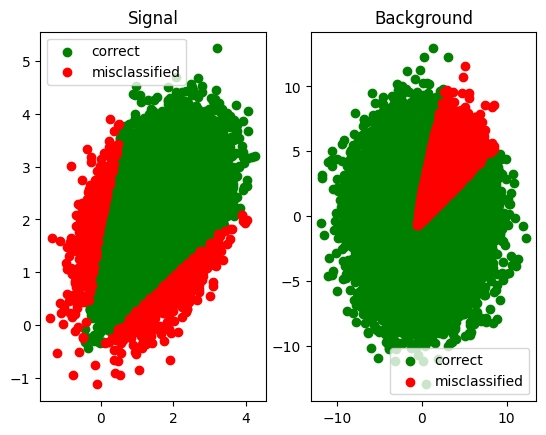

In [17]:
plot_in_and_out(model_sigmoid, params_sigmoid)

And for the `erf` training:

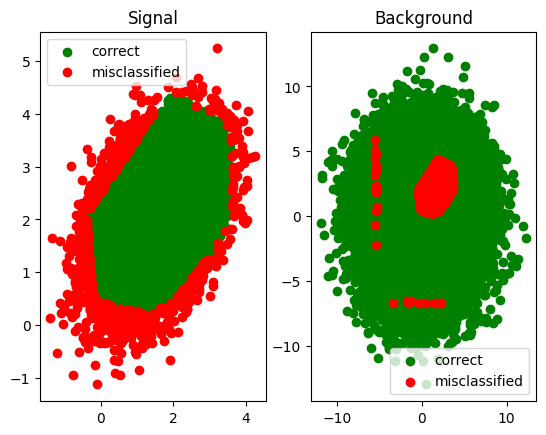

In [18]:
plot_in_and_out(model_erf, params_erf)

Clearly with the same training, the error function did a lot better!

And the very negative training (that started out at -60,-60):

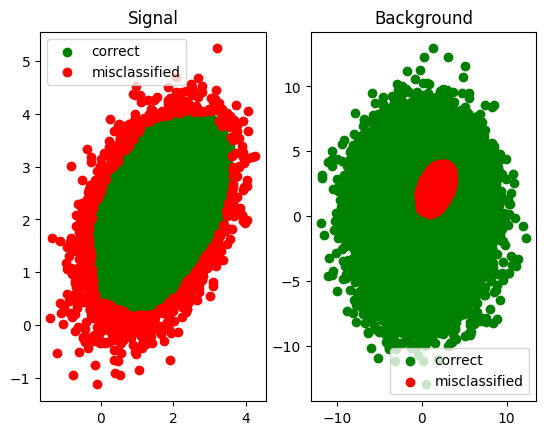

In [19]:
plot_in_and_out(model_sigmoid_negative, params_sigmoid_negative)

As expected, this is as good as a NN only training.

Problems so far:

1. The training when it starts out very negative doesn't ever come back to a reasonable cut.
1. When the cut is in a reasonable place, it seems to be pushed further out all the time.

## Understanding Loss for Cut Values

Lets take the perfectly trained NN (that was started at `(-60,-60)`) and understand what the loss is as we move one of the cuts in.

In [42]:
from jax_training import default_loss, loss_calc

def calc_loss_range(model, start_params, cut_range=(-60, 60)):

    def calc_loss_at(loss_func, params, cut_x = -60.0, cut_y=-60.0):
        params_var['SelectionCut']['cuts'] = jnp.array([cut_x, cut_y])

        return loss_func(params_var, training_data, training_truth)

    key = jax.random.PRNGKey(1234)
    loss_function = loss_calc(model, key, default_loss)

    params_var = deepcopy(start_params)
    cut_values = list(range(cut_range[0], cut_range[1]))
    loss_values = [float(calc_loss_at(loss_function, params_var, cut_x = x))
        for x in cut_values
    ]

    return cut_values, loss_values

cut_values, loss_values = calc_loss_range(model_sigmoid_negative, params_sigmoid_negative)

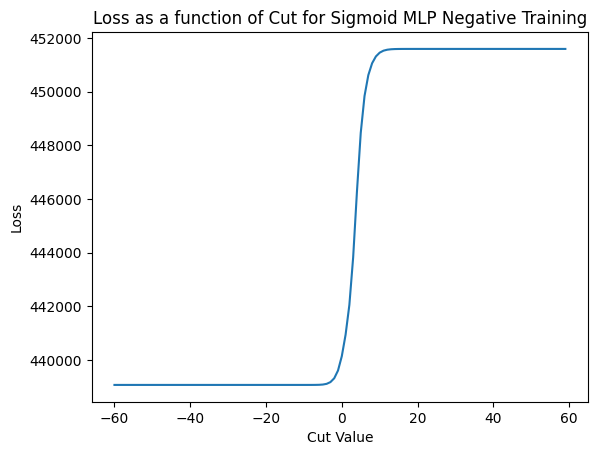

In [43]:
plt.plot(cut_values, loss_values)
plt.ylabel('Loss')
plt.xlabel('Cut Value')
plt.title('Loss as a function of Cut for Sigmoid MLP Negative Training')
plt.show()

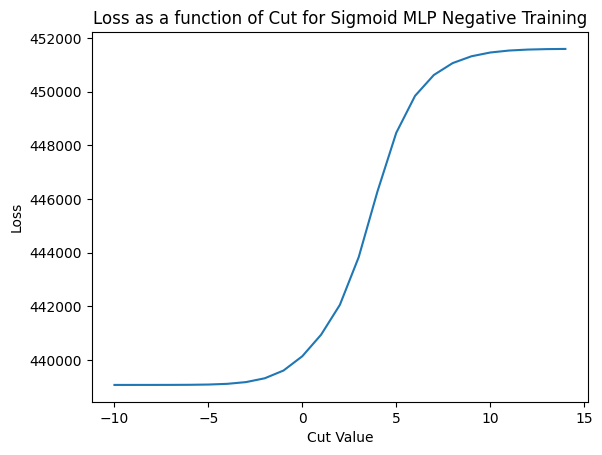

In [49]:
cut_values, loss_values = calc_loss_range(model_sigmoid_negative, params_sigmoid_negative, cut_range=(-10, 15))
plt.plot(cut_values, loss_values)
plt.ylabel('Loss')
plt.xlabel('Cut Value')
plt.title('Loss as a function of Cut for Sigmoid MLP Negative Training')
plt.show()

In [51]:
print(loss_values[:5])
print(cut_values[:5])

[439075.3125, 439075.3125, 439075.59375, 439076.65625, 439079.875]
[-10, -9, -8, -7, -6]


We see here that we start to eat into the loss between `-9` and `-8`. How does this look when we make histograms of the data?

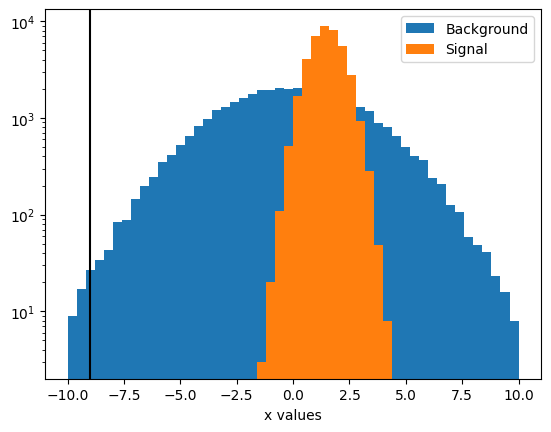

In [68]:
mask_signal = training_truth == 1
mask_background = ~mask_signal
common_args = {
    'bins': 50,
    'range': (-10, 10)
}
plt.hist(training_data[mask_background][:,0], label='Background', **common_args)
plt.hist(training_data[mask_signal][:,0], label='Signal', **common_args)
plt.legend()
plt.yscale('log')
plt.xlabel('x values')
plt.axvline(x = -9.0, color='black')
plt.show()

Something really basic about how this works is wrong - there should be no effect until around -2.5 in the loss function. How we are doing this calculation is not working properly. This is almost certianly the reason behind problem #2 listed above.